# Process steam games and bundles data to final game metadata

In [1]:
import pandas as pd
import numpy as np
import json

## Process Steam Games data

### Clean steam games data

In [2]:
games = pd.read_json('../data/steam_games_fixed.json')

In [3]:
games = games.dropna(subset=["id", "app_name"])

In [4]:
games = games.drop_duplicates(["id"])

In [5]:
list(games.price)

[4.99,
 'Free To Play',
 'Free to Play',
 0.99,
 2.99,
 3.99,
 9.99,
 18.99,
 29.99,
 nan,
 nan,
 'Free',
 10.99,
 3.99,
 2.99,
 1.5899999999999999,
 14.99,
 1.99,
 59.99,
 4.99,
 2.99,
 0.99,
 0.99,
 2.99,
 2.99,
 4.99,
 4.99,
 9.99,
 9.99,
 1.99,
 3.99,
 nan,
 nan,
 0.99,
 nan,
 nan,
 nan,
 8.99,
 0.99,
 6.99,
 6.99,
 9.99,
 nan,
 nan,
 nan,
 nan,
 7.99,
 nan,
 10.99,
 9.99,
 9.99,
 29.99,
 1.99,
 nan,
 0.99,
 9.99,
 9.99,
 9.99,
 9.99,
 39.99,
 'Free',
 4.99,
 4.99,
 4.99,
 19.99,
 9.99,
 7.49,
 14.99,
 9.99,
 4.99,
 9.99,
 4.99,
 9.99,
 9.99,
 4.99,
 4.99,
 4.99,
 8.99,
 19.99,
 19.99,
 4.99,
 nan,
 19.99,
 4.99,
 14.99,
 4.99,
 4.99,
 4.99,
 2.99,
 2.99,
 9.99,
 2.99,
 4.99,
 4.99,
 12.99,
 19.99,
 12.99,
 12.99,
 9.99,
 4.99,
 6.99,
 nan,
 nan,
 9.99,
 9.99,
 9.99,
 6.99,
 9.99,
 19.99,
 9.99,
 9.99,
 9.99,
 9.99,
 9.99,
 5.99,
 7.99,
 9.99,
 9.99,
 4.99,
 2.99,
 19.99,
 2.99,
 14.99,
 9.99,
 4.99,
 9.99,
 9.99,
 9.99,
 9.99,
 9.99,
 9.99,
 4.99,
 9.99,
 9.99,
 9.99,
 9.99,
 9.99

In [6]:
# Change price of free and demo games to 0
free_or_demo = games['price'].astype(str).str.contains("Free|free|Demo|demo")
games.loc[free_or_demo, 'price'] = 0

In [7]:
# Coerce price to numeric, this will change non numeric values to 0
games.loc[:,'price'] = pd.to_numeric(games.price, errors='coerce') 

### Add price category

In [8]:
games.price.value_counts().sort_index()

0.00      1902
0.49         2
0.50         1
0.89         1
0.95         1
          ... 
399.99       2
499.99       2
599.00       1
771.71       1
995.00       1
Name: price, Length: 145, dtype: int64

In [9]:
# create feature for game price category
bins = [-1, 0, 10, 60, 1000]
labels= ['Free', 'Low', 'Medium', 'High']
games['price_category'] = pd.cut(games['price'], bins=bins, labels=labels)

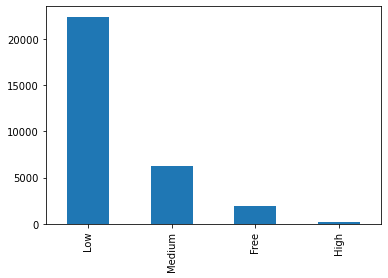

In [10]:
pd.value_counts(games['price_category']).plot(kind="bar")

### Add release year

In [11]:
# create feature for game release year
games['release_year'] = games['release_date'].apply(lambda s: pd.to_datetime(s, errors='coerce').year)

In [12]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32131 entries, 0 to 32134
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   publisher       24081 non-null  object  
 1   genres          28849 non-null  object  
 2   app_name        32131 non-null  object  
 3   title           30083 non-null  object  
 4   url             32131 non-null  object  
 5   release_date    30065 non-null  object  
 6   tags            31969 non-null  object  
 7   discount_price  224 non-null    float64 
 8   reviews_url     32131 non-null  object  
 9   specs           31462 non-null  object  
 10  price           30747 non-null  float64 
 11  early_access    32131 non-null  bool    
 12  id              32131 non-null  float64 
 13  developer       28834 non-null  object  
 14  sentiment       24950 non-null  object  
 15  metascore       2675 non-null   object  
 16  price_category  30747 non-null  category
 17  release_year

## Bundle data: create item-bundle mapping and add to games metadata

In [13]:
with open('../data/bundle_data_fixed.json') as f:
    df_items = json.load(f)   
    bundle_df = pd.json_normalize(data=df_items, 
                              record_path='items',
                              meta=['bundle_final_price', 'bundle_url', 'bundle_price', 'bundle_name', 'bundle_id', 'bundle_discount'])

In [14]:
bundle_df.shape

(3525, 11)

In [15]:
bundle_df.drop_duplicates(subset=["item_id", "bundle_id"], inplace=True)

In [16]:
# convert item id to numeric, results will be float though item id is integer, coerce includes nan so can only be float) which is corresponding to the item id in games metadata
bundle_df.item_id = pd.to_numeric(bundle_df.item_id, errors='coerce') 

In [17]:
bundle_df.dropna(subset=["item_id"], inplace=True)

In [18]:
bundle_df.item_id = bundle_df.item_id.astype(int)
bundle_df

,genre,item_id,discounted_price,item_url,item_name,bundle_final_price,bundle_url,bundle_price,bundle_name,bundle_id,bundle_discount
0,"Adventure, Indie, RPG",326950,$8.99,http://store.steampowered.com/app/326950,Sword of Asumi,$66.46,http://store.steampowered.com/bundle/450/?utm_...,$73.86,Dharker Studio 2015 Complete,450,10%
1,"Adventure, Indie, RPG",331490,$2.99,http://store.steampowered.com/app/331490,Sword of Asumi - Soundtrack,$66.46,http://store.steampowered.com/bundle/450/?utm_...,$73.86,Dharker Studio 2015 Complete,450,10%
2,"Adventure, Indie, RPG",331491,$1.99,http://store.steampowered.com/app/331491,Sword of Asumi - Graphic Novel,$66.46,http://store.steampowered.com/bundle/450/?utm_...,$73.86,Dharker Studio 2015 Complete,450,10%
3,"Adventure, Indie, RPG",331492,$0.99,http://store.steampowered.com/app/331492,Sword of Asumi - Character Creator,$66.46,http://store.steampowered.com/bundle/450/?utm_...,$73.86,Dharker Studio 2015 Complete,450,10%
4,"Adventure, Casual, Indie",348540,$12.99,http://store.steampowered.com/app/348540,Divine Slice of Life,$66.46,http://store.steampowered.com/bundle/450/?utm_...,$73.86,Dharker Studio 2015 Complete,450,10%
...,...,...,...,...,...,...,...,...,...,...,...
3520,"Action, Adventure, Casual, Indie",467220,$4.99,http://store.steampowered.com/app/467220,Dyna Bomb,$5.58,http://store.steampowered.com/bundle/588/?utm_...,$6.98,Dyna Bomb - Game + OST Pack #1,588,20%
3521,"Action, Adventure, Casual, Indie",485090,$1.99,http://store.steampowered.com/app/485090,Dyna Bomb - Soundtrack OST,$5.58,http://store.steampowered.com/bundle/588/?utm_...,$6.98,Dyna Bomb - Game + OST Pack #1,588,20%
3522,"Action, Adventure, Indie",385230,$1.99,http://store.steampowered.com/app/385230,Ninjahtic,$4.77,http://store.steampowered.com/bundle/594/?utm_...,$5.97,The Ninjahtic Series,594,20%
3523,"Action, Adventure, Indie",387880,$1.99,http://store.steampowered.com/app/387880,Ninjahtic Mind Tricks,$4.77,http://store.steampowered.com/bundle/594/?utm_...,$5.97,The Ninjahtic Series,594,20%


In [19]:
item_bundle_df = bundle_df[["item_id", "bundle_name"]].groupby('item_id')['bundle_name'].apply(list).reset_index(name='bundles')

In [20]:
item_bundle_df = item_bundle_df.rename({"item_id": "id"}, axis='columns')

In [21]:
item_bundle_df

,id,bundles
0,20,"[Half-Life Complete, Valve Complete Pack, Half..."
1,30,"[Valve Complete Pack, Counter-Strike 1 Anthology]"
2,40,"[Valve Complete Pack, Counter-Strike 1 Anthology]"
3,50,"[Half-Life Complete, Valve Complete Pack, Half..."
4,60,"[Valve Complete Pack, Counter-Strike 1 Anthology]"
...,...,...
2782,528389,"[Naruto Shippuden Uncut Season 4, Vol. 4]"
2783,528390,"[Naruto Shippuden Uncut Season 4, Vol. 4]"
2784,528391,"[Naruto Shippuden Uncut Season 4, Vol. 4]"
2785,528392,"[Naruto Shippuden Uncut Season 4, Vol. 4]"


## Merge bundle info into metadata

In [22]:
games_metadata = games.merge(item_bundle_df, how='left', on='id')

In [23]:
games_metadata

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore,price_category,release_year,bundles
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140.0,Kotoshiro,NaN,NaN,Low,2018.0,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",0.00,False,643980.0,Secret Level SRL,Mostly Positive,NaN,Free,2018.0,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",0.00,False,670290.0,Poolians.com,Mostly Positive,NaN,Free,2017.0,NaN
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",0.83,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.99,False,767400.0,彼岸领域,NaN,NaN,Low,2017.0,NaN
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"[Action, Indie, Casual, Sports]",1.79,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.99,False,773570.0,NaN,NaN,NaN,Low,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32126,Ghost_RUS Games,"[Casual, Indie, Simulation, Strategy]",Colony On Mars,Colony On Mars,http://store.steampowered.com/app/773640/Colon...,2018-01-04,"[Strategy, Indie, Casual, Simulation]",1.49,http://steamcommunity.com/app/773640/reviews/?...,"[Single-player, Steam Achievements]",1.99,False,773640.0,"Nikita ""Ghost_RUS""",NaN,NaN,Low,2018.0,NaN
32127,Sacada,"[Casual, Indie, Strategy]",LOGistICAL: South Africa,LOGistICAL: South Africa,http://store.steampowered.com/app/733530/LOGis...,2018-01-04,"[Strategy, Indie, Casual]",4.24,http://steamcommunity.com/app/733530/reviews/?...,"[Single-player, Steam Achievements, Steam Clou...",4.99,False,733530.0,Sacada,NaN,NaN,Low,2018.0,NaN
32128,Laush Studio,"[Indie, Racing, Simulation]",Russian Roads,Russian Roads,http://store.steampowered.com/app/610660/Russi...,2018-01-04,"[Indie, Simulation, Racing]",1.39,http://steamcommunity.com/app/610660/reviews/?...,"[Single-player, Steam Achievements, Steam Trad...",1.99,False,610660.0,Laush Dmitriy Sergeevich,NaN,NaN,Low,2018.0,NaN
32129,SIXNAILS,"[Casual, Indie]",EXIT 2 - Directions,EXIT 2 - Directions,http://store.steampowered.com/app/658870/EXIT_...,2017-09-02,"[Indie, Casual, Puzzle, Singleplayer, Atmosphe...",NaN,http://steamcommunity.com/app/658870/reviews/?...,"[Single-player, Steam Achievements, Steam Cloud]",4.99,False,658870.0,"xropi,stev3ns",1 user reviews,NaN,Low,2017.0,NaN


In [24]:
games_metadata.to_csv("../processed_data/games_metadata.csv", index=False)